## Step 1: Imports & Setup for Data Loading

In [2]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Display
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Load datasets
spring = pd.read_csv('spring_dataset.csv')
winter = pd.read_csv('winter_dataset.csv')

# Add season labels if not present
spring['season'] = spring.get('season', 1)
winter['season'] = winter.get('season', 0)

# Normalize column names (strip spaces, lower)
spring.columns = [c.strip().lower() for c in spring.columns]
winter.columns = [c.strip().lower() for c in winter.columns]

# Quick sanity checks
print("Spring shape:", spring.shape)
print("Winter shape:", winter.shape)
print("Spring columns:", spring.columns.tolist())
print("Winter columns:", winter.columns.tolist())

Spring shape: (1702, 19)
Winter shape: (1056, 19)
Spring columns: ['time', 'bat_landing_to_food', 'habit', 'rat_period_start', 'rat_period_end', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'sunset_time', 'hours_after_sunset', 'season', 'fight', 'dataset', 'bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_present']
Winter columns: ['time', 'bat_landing_to_food', 'habit', 'rat_period_start', 'rat_period_end', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'sunset_time', 'hours_after_sunset', 'season', 'fight', 'dataset', 'bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number', 'rat_present']


## Feature Engineering

In [3]:
# Harmonize similar fields across datasets-naming differences
# In winter, 'rat_arrival' seems analogous to 'rat_arrival_number'
if 'rat_arrival' in winter.columns and 'rat_arrival_number' not in winter.columns:
    winter['rat_arrival_number'] = winter['rat_arrival']

# Ensure numeric types where appropriate
def to_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

numeric_cols = [
    'bat_landing_to_food','seconds_after_rat_arrival','risk','reward',
    'hours_after_sunset','bat_landing_number','food_availability',
    'rat_minutes','rat_arrival_number','month','fight'
]
spring = to_numeric(spring, numeric_cols)
winter = to_numeric(winter, numeric_cols)

# Encode month/season per spec (Northern Hemisphere assumption):
# Spring (season=1): Month=0,1,2 -> March, April, May; Winter (season=0): Month=3,4,5 -> Dec, Jan, Feb
# If month missing, infer from season or leave as-is
def map_month_name(m, season):
    mapping_spring = {0: 'March', 1: 'April', 2: 'May'}
    mapping_winter = {3: 'December', 4: 'January', 5: 'February'}
    if pd.isna(m):
        return np.nan
    if season == 1:
        return mapping_spring.get(int(m), np.nan)
    else:
        return mapping_winter.get(int(m), np.nan)

for df in (spring, winter):
    df['month_name'] = df.apply(lambda r: map_month_name(r.get('month', np.nan), r.get('season', np.nan)), axis=1)

# Presence of rats: binary if rat_minutes > 0 or rat_arrival_number > 0
def rat_presence(df):
    rm = df.get('rat_minutes')
    ra = df.get('rat_arrival_number')
    df['rat_present'] = ((rm.fillna(0) > 0) | (ra.fillna(0) > 0)).astype(int)
    return df

spring = rat_presence(spring)
winter = rat_presence(winter)

# Food abundance: categorize food_availability (low/medium/high) using tertiles
def categorize_food(df):
    if 'food_availability' in df.columns:
        fa = df['food_availability']
        # Handle degenerate cases
        if fa.notna().sum() >= 3 and fa.nunique() >= 3:
            q = fa.quantile([0.33, 0.66])
            df['food_abundance'] = pd.cut(
                fa,
                bins=[-np.inf, q.iloc[0], q.iloc[1], np.inf],
                labels=['low','medium','high']
            )
        else:
            # Fallback: binary split
            median = fa.median()
            df['food_abundance'] = np.where(fa <= median, 'low', 'high')
    else:
        df['food_abundance'] = np.nan
    return df

spring = categorize_food(spring)
winter = categorize_food(winter)

# Night period: Early vs Late night based on hours_after_sunset
def night_period(val):
    try:
        return 'Early night' if float(val) < 3 else 'Late night'
    except:
        return np.nan

for df in (spring, winter):
    df['night_period'] = df['hours_after_sunset'].apply(night_period) if 'hours_after_sunset' in df.columns else np.nan

# Vigilance proxy engineering:
# Concept: vigilance increases when bats approach food quickly despite rat presence and/or take risks or fight.
# We'll standardize continuous components and combine:
# Components (use if available):
# inverse bat_landing_to_food (faster approach -> higher vigilance)
# negative seconds_after_rat_arrival (landing closer to rat arrival -> higher vigilance)
# risk (1 -> higher vigilance)
# fight (if present; higher implies engagement)
# presence of rats (rat_present)

def zscore(series):
    s = pd.to_numeric(series, errors='coerce')
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

def build_vigilance(df):
    comps = []
    if 'bat_landing_to_food' in df.columns:
        comps.append(-zscore(df['bat_landing_to_food']))  # shorter delay => higher vigilance
    else:
        comps.append(pd.Series(np.zeros(len(df))))

    if 'seconds_after_rat_arrival' in df.columns:
        comps.append(-zscore(df['seconds_after_rat_arrival']))  # landing closer to rat arrival => higher vigilance
    else:
        comps.append(pd.Series(np.zeros(len(df))))

    if 'risk' in df.columns:
        comps.append(zscore(df['risk']))  # risk-taking
    else:
        comps.append(pd.Series(np.zeros(len(df))))

    if 'fight' in df.columns:
        comps.append(zscore(df['fight']))  # engagement intensity if numeric
    else:
        comps.append(pd.Series(np.zeros(len(df))))

    if 'rat_present' in df.columns:
        comps.append(zscore(df['rat_present']))
    else:
        comps.append(pd.Series(np.zeros(len(df))))

    df['vigilance_proxy'] = np.nanmean(np.vstack([c.fillna(0).values for c in comps]), axis=0)
    return df

spring = build_vigilance(spring)
winter = build_vigilance(winter)

# Categorical encodings for modeling
for df in (spring, winter):
    # One-hot encode habit if present
    if 'habit' in df.columns:
        df['habit'] = df['habit'].astype(str)
        habit_d = pd.get_dummies(df['habit'], prefix='habit', drop_first=True)
        df[habit_d.columns] = habit_d

    # One-hot encode food_abundance
    if 'food_abundance' in df.columns:
        df['food_abundance'] = df['food_abundance'].astype('category')
        fa_d = pd.get_dummies(df['food_abundance'], prefix='food', drop_first=True)
        df[fa_d.columns] = fa_d

    # One-hot encode night_period
    if 'night_period' in df.columns:
        np_d = pd.get_dummies(df['night_period'], prefix='night', drop_first=True)
        df[np_d.columns] = np_d

    # Month name encoding (optional)
    if 'month_name' in df.columns:
        mn_d = pd.get_dummies(df['month_name'], prefix='month', drop_first=True)
        df[mn_d.columns] = mn_d

# Ensure reward is numeric (binary if authored as label)
for df in (spring, winter):
    if 'reward' in df.columns and df['reward'].dtype == 'O':
        df['reward'] = df['reward'].map({'no':0,'yes':1}).fillna(pd.to_numeric(df['reward'], errors='coerce'))

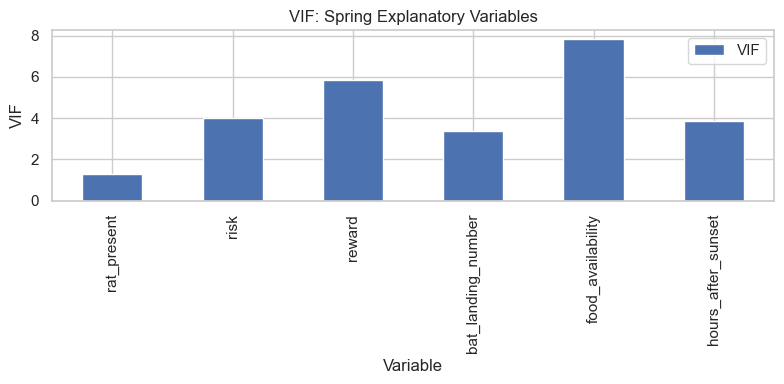

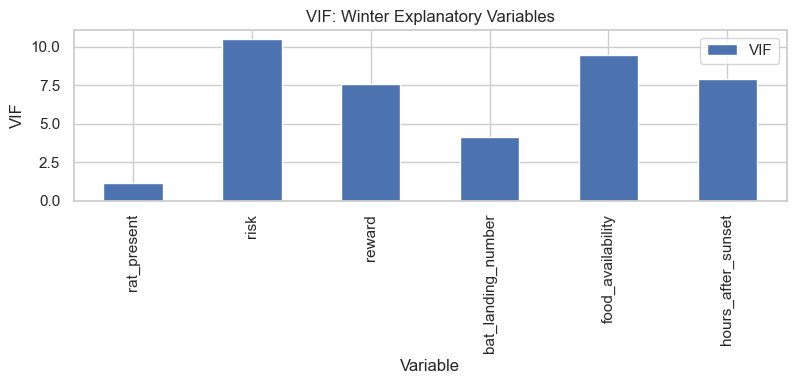

In [19]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, impute_strategy='mean', fill_constant=False):
    # Ensure DataFrame
    X = pd.DataFrame(df).copy()

    # Keep only numeric columns
    X = X.select_dtypes(include=[np.number])
    if X.shape[1] == 0:
        raise ValueError("No numeric columns found for VIF calculation")

    # Drop columns that are entirely NaN
    X = X.dropna(axis=1, how='all')
    if X.shape[1] == 0:
        raise ValueError("All numeric columns are empty (all NaN)")

    # Drop constant columns (zero variance) because VIF undefined
    nunique = X.nunique(dropna=True)
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        X = X.drop(columns=const_cols)

    if X.shape[1] == 0:
        raise ValueError("No non-constant numeric columns available for VIF")

    # Impute remaining NaNs
    if impute_strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif impute_strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif impute_strategy == 'constant':
        imputer = SimpleImputer(strategy='constant', fill_value=0 if fill_constant else np.nan)
    else:
        raise ValueError("Unsupported impute_strategy")

    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, dtype=float)

    # Check for inf / nan after imputation
    if not np.isfinite(X_imputed.values).all():
        raise ValueError("X contains non-finite values after imputation")

    # Compute VIF
    vif_data = []
    for i in range(X_imputed.shape[1]):
        try:
            vif_val = variance_inflation_factor(X_imputed.values, i)
        except Exception as e:
            vif_val = np.nan
        vif_data.append(vif_val)

    vif_df = pd.DataFrame({
        'Variable': X_imputed.columns,
        'VIF': vif_data
    })
    return vif_df

# Example usage for spring and winter (use the cleaned training DataFrames you used for modeling)
vif_spring = calculate_vif(X_train_spring)   # X_train_spring should be the DataFrame used before model fit
vif_spring.plot.bar(x='Variable', y='VIF', figsize=(8,4))
plt.title('VIF: Spring Explanatory Variables')
plt.ylabel('VIF')
plt.tight_layout()
plt.show()

vif_winter = calculate_vif(X_train_winter)
vif_winter.plot.bar(x='Variable', y='VIF', figsize=(8,4))
plt.title('VIF: Winter Explanatory Variables')
plt.ylabel('VIF')
plt.tight_layout()
plt.show()

## Candidate Variables and LR Response

In [4]:
# Define candidate explanatory variables (only those present in each dataset will be used)
candidate_X = [
    'rat_present','rat_minutes','rat_arrival_number',
    'food_availability','hours_after_sunset','bat_landing_number',
    'risk','reward','seconds_after_rat_arrival','bat_landing_to_food',
    # Encoded categorical dummies (may or may not exist)
    'food_medium','food_high',
    'night_Late night',
    # habit dummies and month dummies added dynamically
]

# Utility to get available X columns
def get_Xy(df, response='vigilance_proxy', base_candidates=candidate_X):
    # Gather available dummy columns for habit/month/food/night
    dynamic = [c for c in df.columns if c.startswith('habit_') or c.startswith('month_') or c.startswith('food_') or c.startswith('night_')]
    cols = list(set(base_candidates + dynamic))
    available = [c for c in cols if c in df.columns]
    X = df[available].copy()
    y = df[response].copy()
    # Drop rows with missing response
    valid = y.notna()
    X = X[valid]
    y = y[valid]
    # Fill NA in X
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    return X, y

X_spring, y_spring = get_Xy(spring)
X_winter, y_winter = get_Xy(winter)

print("Spring X shape:", X_spring.shape, "y:", y_spring.shape)
print("Winter X shape:", X_winter.shape, "y:", y_winter.shape)

Spring X shape: (1702, 21) y: (1702,)
Winter X shape: (1056, 21) y: (1056,)


## Descriptive Analysis

In [5]:
# Select core numeric variables for description
desc_vars = [
    'vigilance_proxy','bat_landing_to_food','seconds_after_rat_arrival',
    'hours_after_sunset','food_availability','rat_minutes','rat_arrival_number',
    'bat_landing_number','risk','reward'
]
def summary_stats(df, label):
    cols = [c for c in desc_vars if c in df.columns]
    stats = df[cols].describe().T[['mean','50%','std']].rename(columns={'50%':'median'})
    # Variance separately to avoid ddof confusion
    stats['variance'] = df[cols].var(ddof=1)
    print(f"\nDescriptive statistics ({label}):")
    display(stats)

summary_stats(spring, 'Spring')
summary_stats(winter, 'Winter')


Descriptive statistics (Spring):


,mean,median,std,variance
vigilance_proxy,1.669901e-17,-0.107046,0.314859,0.099136
bat_landing_to_food,1.256559e+01,4.000000,26.444252,699.298458
seconds_after_rat_arrival,2.907368e+02,210.000000,243.278198,59184.281611
hours_after_sunset,5.806475e+00,5.951667,3.214576,10.333500
food_availability,2.329274e+00,2.821164,1.038500,1.078483
rat_minutes,2.586336e+00,0.000000,5.290754,27.992079
rat_arrival_number,6.047170e-01,0.000000,1.022586,1.045681
bat_landing_number,3.086509e+01,25.000000,26.297630,691.565353
risk,4.844237e-01,0.000000,0.500147,0.250147
reward,5.825545e-01,1.000000,0.493522,0.243564



Descriptive statistics (Winter):


,mean,median,std,variance
vigilance_proxy,-1.177509e-17,-0.073284,0.270964,0.073421
bat_landing_to_food,1.002630e+01,3.000000,31.671206,1003.065313
seconds_after_rat_arrival,2.525234e+02,199.000000,220.308162,48535.686416
hours_after_sunset,5.892388e+00,5.500000,3.463635,11.996764
food_availability,2.243362e+00,2.086587,1.318464,1.738347
rat_minutes,4.781770e-01,0.000000,1.681297,2.826759
rat_arrival_number,2.496955e-01,0.000000,0.945988,0.894893
bat_landing_number,3.870037e+01,37.000000,24.438531,597.241817
risk,5.659574e-01,1.000000,0.496688,0.246699
reward,4.340426e-01,0.000000,0.496688,0.246699


## Descriptive Analysis - Data Visualization

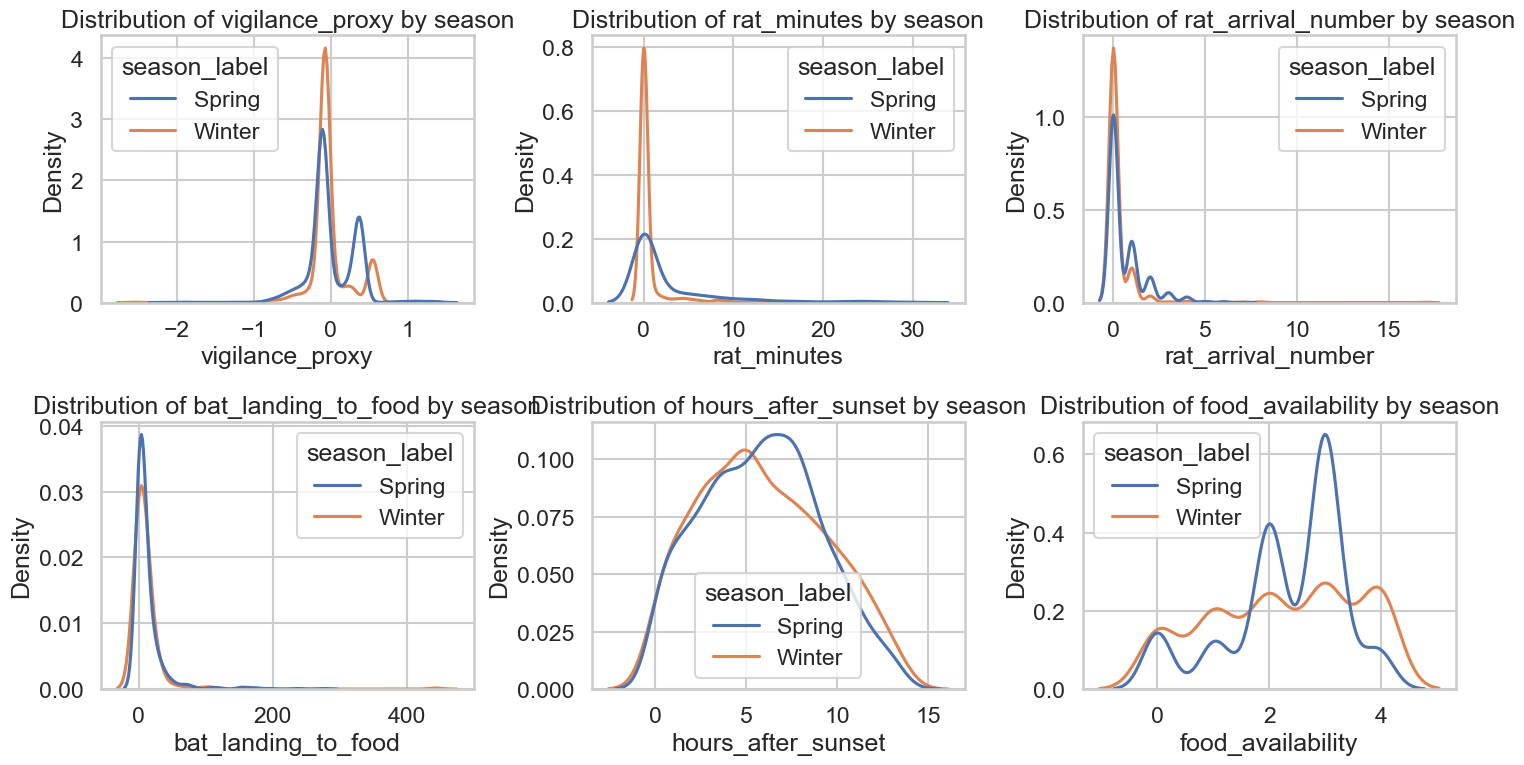

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove duplicate columns in both subsets
spring = spring.loc[:, ~spring.columns.duplicated()]
winter = winter.loc[:, ~winter.columns.duplicated()]

plot_vars = [
    v for v in [
        'vigilance_proxy','rat_minutes','rat_arrival_number',
        'bat_landing_to_food','hours_after_sunset','food_availability'
    ]
    if v in spring.columns and v in winter.columns
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

combined = pd.concat([
    spring.assign(season_label='Spring'),
    winter.assign(season_label='Winter')
], ignore_index=True)

for ax, var in zip(axes.flatten(), plot_vars[:6]):
    sns.kdeplot(
        data=combined,
        x=var,
        hue='season_label',
        common_norm=False,
        ax=ax
    )
    ax.set_title(f"Distribution of {var} by season")

plt.tight_layout()
plt.show()

## Inferential Analaysis

T-tests (Spring vs Winter):
rat_minutes: t=12.202, p=1.58e-32, equal_var=False, n_spring=1060, n_winter=821
rat_arrival_number: t=7.791, p=1.11e-14, equal_var=False, n_spring=1060, n_winter=821
vigilance_proxy: t=0.000, p=1, equal_var=False, n_spring=1702, n_winter=1056


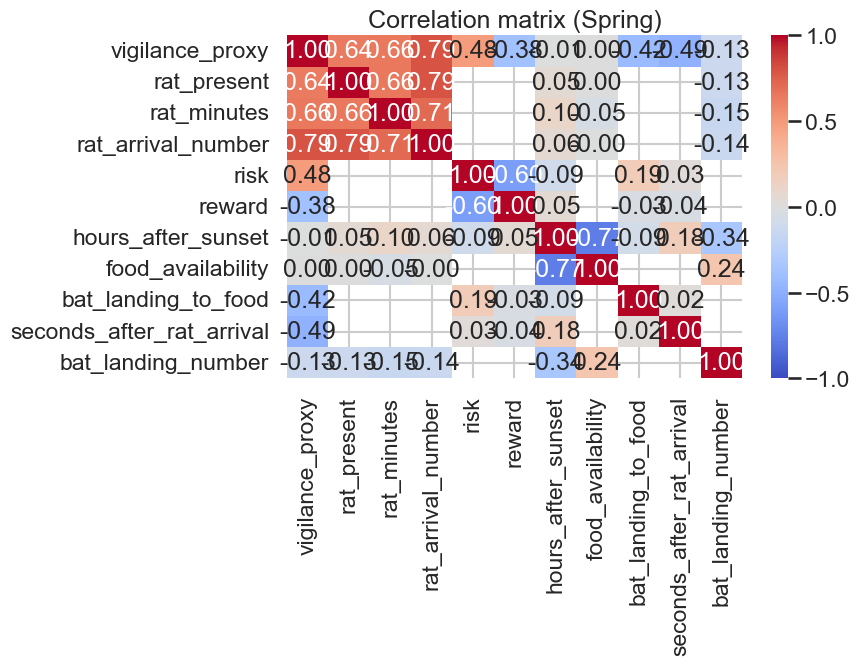

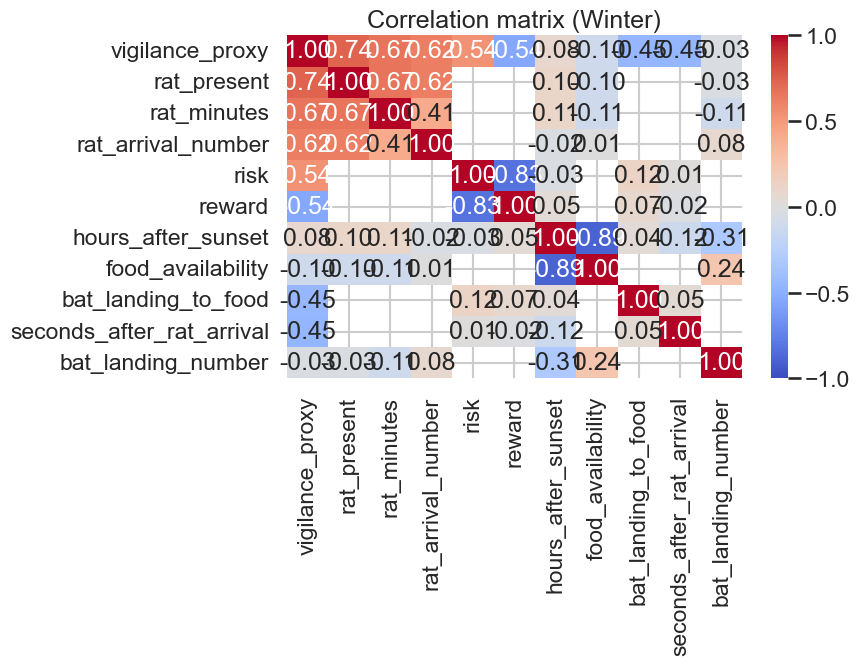

In [8]:
from scipy import stats

# Hypothesis: Spring shows higher rat presence/activity than Winter
# Test on rat_minutes and rat_arrival_number
def t_test_var(var):
    if var in spring.columns and var in winter.columns:
        s = spring[var].dropna()
        w = winter[var].dropna()
        # Levene test for equal variances
        lev_p = stats.levene(s, w).pvalue
        equal_var = lev_p > 0.05
        t_stat, p_val = stats.ttest_ind(s, w, equal_var=equal_var)
        print(f"{var}: t={t_stat:.3f}, p={p_val:.3g}, equal_var={equal_var}, n_spring={len(s)}, n_winter={len(w)}")

print("T-tests (Spring vs Winter):")
t_test_var('rat_minutes')
t_test_var('rat_arrival_number')
t_test_var('vigilance_proxy')

# Correlation analysis within each season for variables tied to rat presence and vigilance
corr_vars = [v for v in ['vigilance_proxy','rat_present','rat_minutes','rat_arrival_number','risk','reward','hours_after_sunset','food_availability','bat_landing_to_food','seconds_after_rat_arrival','bat_landing_number'] if v in spring.columns]

def corr_plot(df, label):
    corr = df[corr_vars].corr()
    plt.figure(figsize=(9,7))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation matrix ({label})")
    plt.tight_layout()
    plt.show()

corr_plot(spring, 'Spring')
corr_plot(winter, 'Winter')

## LR Modelling for Winter and Spring

In [9]:
# Train-test split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_spring, y_spring, test_size=0.2, random_state=42)
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_winter, y_winter, test_size=0.2, random_state=42)

# Scale features for stability (store scaler per season)
scaler_s = StandardScaler()
Xs_train_s = scaler_s.fit_transform(Xs_train)
Xs_test_s = scaler_s.transform(Xs_test)

scaler_w = StandardScaler()
Xw_train_s = scaler_w.fit_transform(Xw_train)
Xw_test_s = scaler_w.transform(Xw_test)

# Fit LR models
lr_spring = LinearRegression()
lr_winter = LinearRegression()

lr_spring.fit(Xs_train_s, ys_train)
lr_winter.fit(Xw_train_s, yw_train)

# Predictions
ys_pred = lr_spring.predict(Xs_test_s)
yw_pred = lr_winter.predict(Xw_test_s)

# Store coefficients back to feature names
coef_spring = pd.Series(lr_spring.coef_, index=Xs_train.columns)
coef_winter = pd.Series(lr_winter.coef_, index=Xw_train.columns)

print("Top spring coefficients:")
display(coef_spring.sort_values(key=abs, ascending=False).head(10))
print("Top winter coefficients:")
display(coef_winter.sort_values(key=abs, ascending=False).head(10))

Top spring coefficients:


rat_present                  0.199244
habit_nan                   -0.175101
seconds_after_rat_arrival   -0.166275
risk                         0.152996
bat_landing_to_food         -0.118418
habit_rat                   -0.066315
reward                      -0.058010
habit_other                 -0.041984
habit_fast                  -0.038540
habit_pick                  -0.031830
dtype: float64

Top winter coefficients:


habit_nan                   -0.213632
rat_present                  0.200066
seconds_after_rat_arrival   -0.123175
habit_rat                   -0.123150
habit_fast                  -0.117864
bat_landing_to_food         -0.100132
risk                         0.098990
habit_pick                  -0.087745
habit_other                 -0.049420
night_Late night             0.004746
dtype: float64

## Model Evaluation Metrics

In [10]:
def eval_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # NRMSE scaled by std of y_true
    nrmse = rmse / (np.std(y_true, ddof=0) + 1e-9)
    print(f"{label} -> MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}")

eval_metrics(ys_test, ys_pred, "Spring")
eval_metrics(yw_test, yw_pred, "Winter")

Spring -> MAE: 0.0256, MSE: 0.0115, RMSE: 0.1073, NRMSE: 0.3227
Winter -> MAE: 0.0218, MSE: 0.0094, RMSE: 0.0972, NRMSE: 0.3592


## Data Visualization _ Pairplot

C:\Users\dlihi\AppData\Local\Temp\ipykernel_6100\3348444302.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined[col].fillna(mean_val, inplace=True)


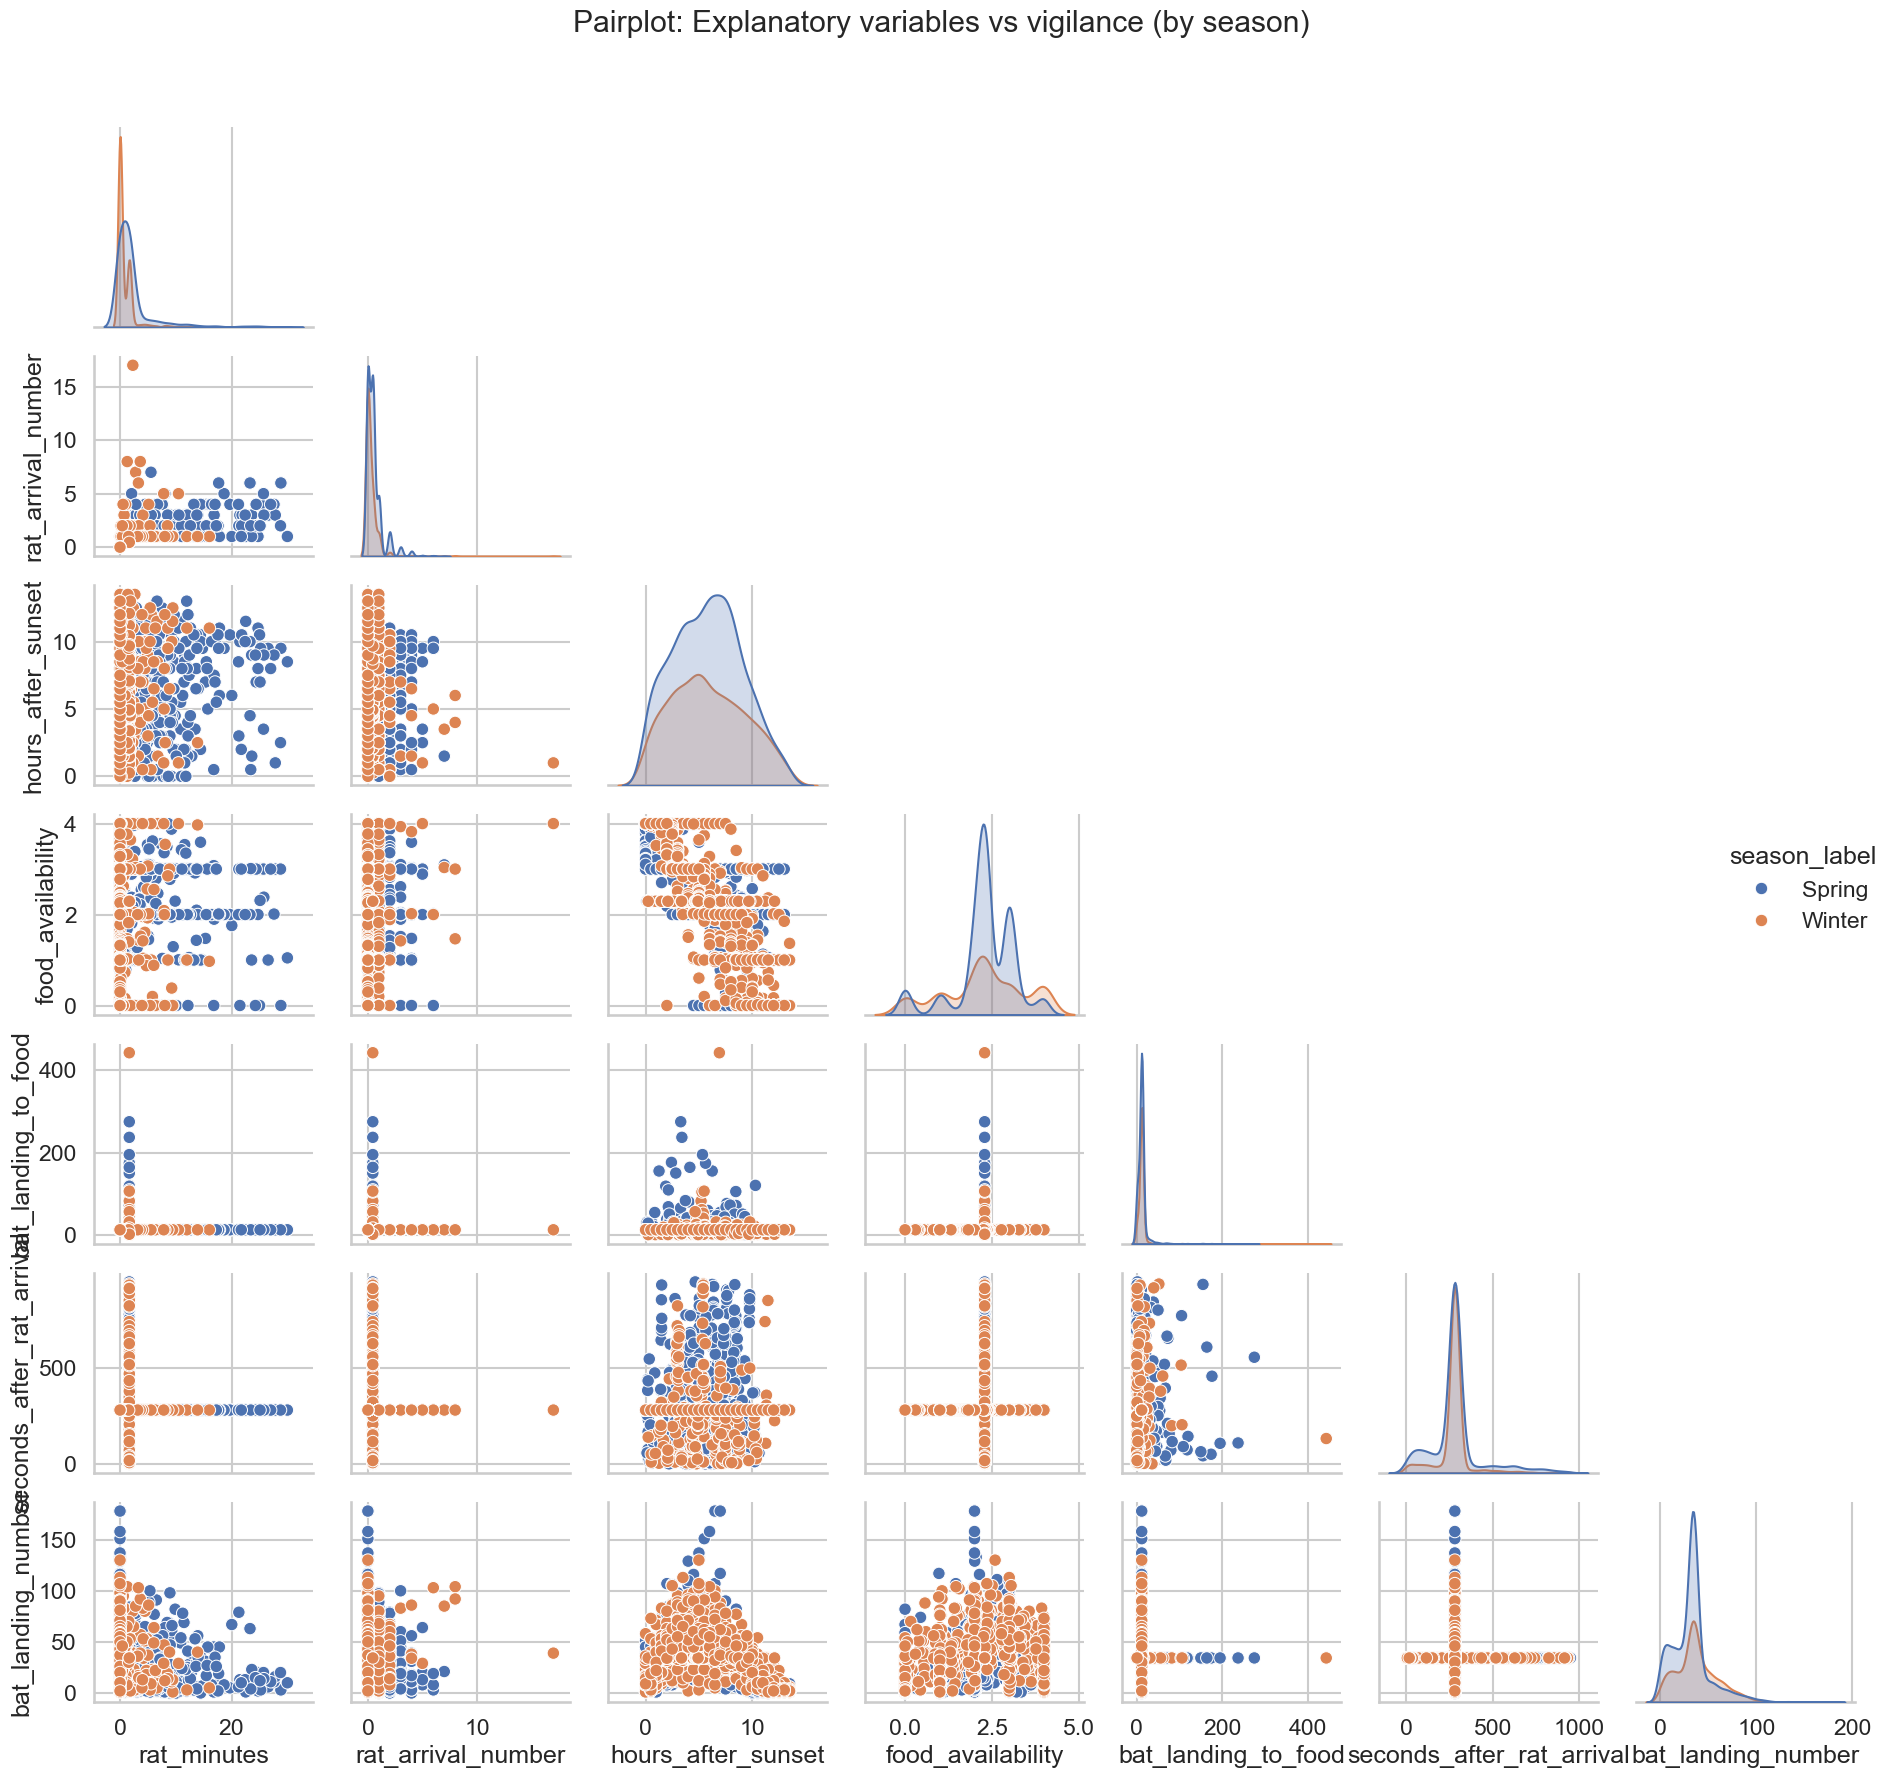

In [16]:
# Combine spring and winter datasets with season labels
combined = pd.concat([
    spring.assign(season_label='Spring'),
    winter.assign(season_label='Winter')
], ignore_index=True)

# Define variables to include in the pairplot
pair_vars = [
    v for v in [
        'vigilance_proxy', 'rat_minutes', 'rat_arrival_number',
        'hours_after_sunset', 'food_availability', 'bat_landing_to_food',
        'seconds_after_rat_arrival', 'bat_landing_number'
    ] if v in combined.columns
]

# Replace missing values with column-wise mean
for col in pair_vars:
    if combined[col].isna().any():
        mean_val = combined[col].mean(skipna=True)
        combined[col].fillna(mean_val, inplace=True)

# Drop rows with missing season label (if any)
combined = combined.dropna(subset=['season_label'])

# Create the pairplot
pp = sns.pairplot(
    data=combined[pair_vars + ['season_label']],
    vars=[v for v in pair_vars if v != 'vigilance_proxy'],
    y_vars=['vigilance_proxy'],
    hue='season_label',
    corner=True,
    height=2.5
)

pp.fig.suptitle("Pairplot: Explanatory variables vs vigilance (by season)", y=1.02)
plt.tight_layout()
plt.show()


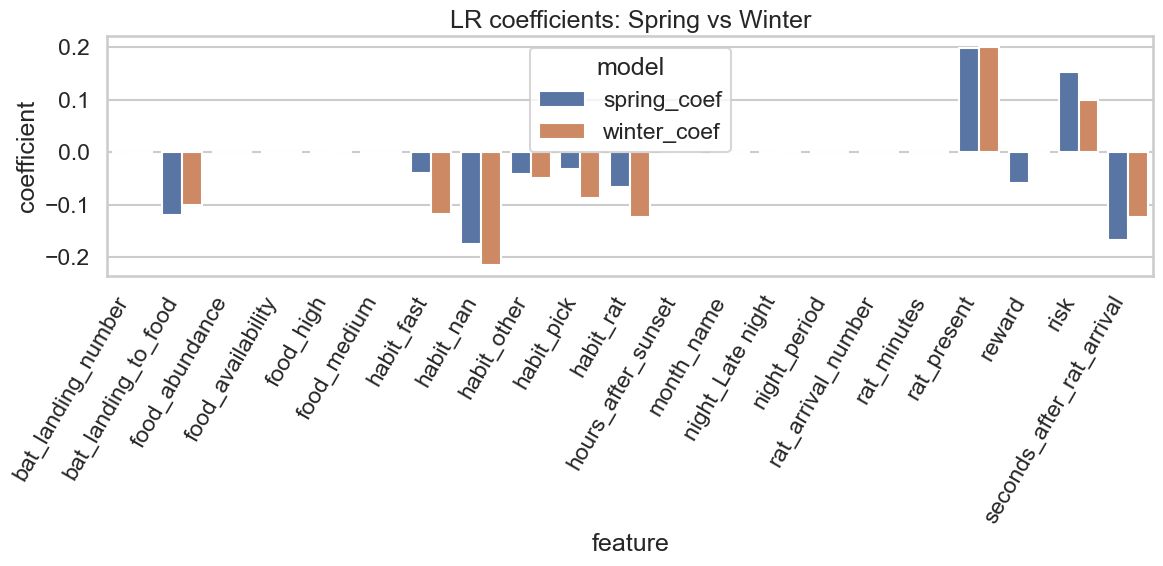

In [12]:
# Coefficient bar graph for LR models (spring vs winter)
# Align coefficients on shared features
shared_feats = sorted(list(set(coef_spring.index).intersection(set(coef_winter.index))))
coef_df = pd.DataFrame({
    'feature': shared_feats,
    'spring_coef': coef_spring[shared_feats].values,
    'winter_coef': coef_winter[shared_feats].values
})
coef_df_m = coef_df.melt(id_vars='feature', var_name='model', value_name='coefficient')

plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df_m, x='feature', y='coefficient', hue='model')
plt.xticks(rotation=60, ha='right')
plt.title("LR coefficients: Spring vs Winter")
plt.tight_layout()
plt.show()

## Data Visualization - Residual Plots

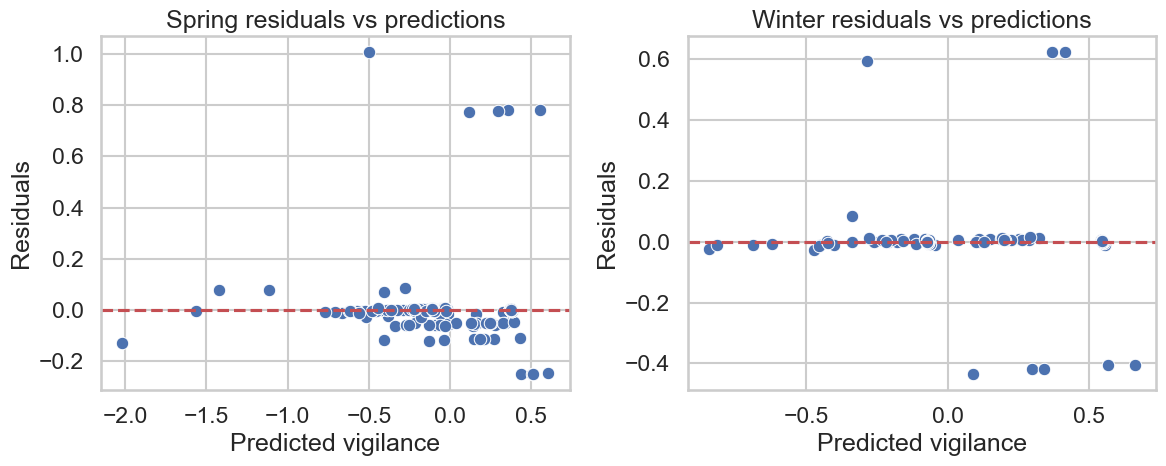

In [13]:
# Residual plots
resid_spring = ys_test - ys_pred
resid_winter = yw_test - yw_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=ys_pred, y=resid_spring, ax=axes[0])
axes[0].axhline(0, color='r', linestyle='--')
axes[0].set_title("Spring residuals vs predictions")
axes[0].set_xlabel("Predicted vigilance")
axes[0].set_ylabel("Residuals")

sns.scatterplot(x=yw_pred, y=resid_winter, ax=axes[1])
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_title("Winter residuals vs predictions")
axes[1].set_xlabel("Predicted vigilance")
axes[1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

##  Multicollinearity: VIF bar chart

C:\Users\dlihi\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\dlihi\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


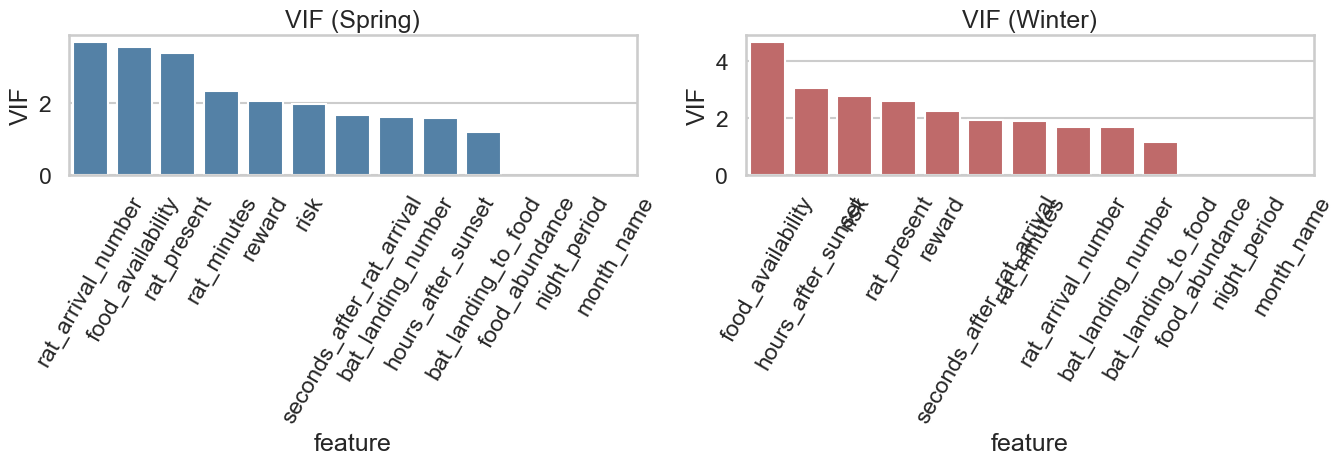

In [14]:
# Multicollinearity: VIF bar chart
def compute_vif(X):
    X_const = sm.add_constant(X)
    # Exclude constant from VIF computation
    vif_data = []
    for i in range(1, X_const.shape[1]):
        vif = variance_inflation_factor(X_const.values, i)
        vif_data.append((X_const.columns[i], vif))
    return pd.DataFrame(vif_data, columns=['feature','VIF'])

vif_spring = compute_vif(X_spring.select_dtypes(include=np.number))
vif_winter = compute_vif(X_winter.select_dtypes(include=np.number))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=vif_spring.sort_values('VIF', ascending=False), x='feature', y='VIF', ax=axes[0], color='steelblue')
axes[0].set_title("VIF (Spring)")
axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data=vif_winter.sort_values('VIF', ascending=False), x='feature', y='VIF', ax=axes[1], color='indianred')
axes[1].set_title("VIF (Winter)")
axes[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()